<a href="https://colab.research.google.com/github/emma35johnson/Spotify/blob/main/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Analysis

This is my first personal Python project, mimicking a project I've already done in `R`, my preferred language for data science.

Here, I'll be exploring the similarities and differences in methodology between the 2 languages, as well as putting my Python skills to the test.

## PART 1: Load Libraries and Data

I'll begin by importing my personal Extended Streaming History files from Spotify. This data begins in 2015 and ends in the fall of 2025. It is in JSON format, so this will be more of a challenge to load than csv files.

In [1]:
# Using these libraries to load the data
import pandas as pd
import glob
import json
import os

Next, with the help of LLMs, I've put the raw data into a dataframe and printed the `head` of the data.

In [2]:
# Define your path and file pattern
path = "/content/drive/MyDrive/Spotify Extended Streaming History"
files = glob.glob(os.path.join(path, "Streaming_History_Audio*.json"))

# Load and combine all JSON files
all_data = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        all_data.extend(data)   # each file is usually a list of dictionaries

# Convert list of dicts to DataFrame
df = pd.DataFrame(all_data)

# Preview
print(df.head())
print(len(df))

                     ts             platform  ms_played conn_country  \
0  2015-11-02T00:36:29Z  iOS 9.1 (iPhone6,1)       9798           US   
1  2015-11-02T00:39:42Z  iOS 9.1 (iPhone6,1)     192381           US   
2  2015-11-02T00:42:53Z  iOS 9.1 (iPhone6,1)     190595           US   
3  2015-11-02T00:45:26Z  iOS 9.1 (iPhone6,1)     121533           US   
4  2015-11-02T00:45:28Z  iOS 9.1 (iPhone6,1)       1904           US   

          ip_addr          master_metadata_track_name  \
0  174.25.247.192  Kanye - Steve Aoki & twoloud Remix   
1  174.25.247.192                           Hide Away   
2  174.25.247.192                          Right Hand   
3  174.25.247.192                      Guts Over Fear   
4  174.25.247.192                           The Hills   

  master_metadata_album_artist_name master_metadata_album_album_name  \
0                  The Chainsmokers                            Kanye   
1                              Daya                             Daya   
2       

For further exploration early on, let's explore the data types and non-null content of each column (aka each feature).

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176214 entries, 0 to 176213
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ts                                 176214 non-null  object 
 1   platform                           176214 non-null  object 
 2   ms_played                          176214 non-null  int64  
 3   conn_country                       176214 non-null  object 
 4   ip_addr                            176214 non-null  object 
 5   master_metadata_track_name         174664 non-null  object 
 6   master_metadata_album_artist_name  174664 non-null  object 
 7   master_metadata_album_album_name   174664 non-null  object 
 8   spotify_track_uri                  174664 non-null  object 
 9   episode_name                       1543 non-null    object 
 10  episode_show_name                  1543 non-null    object 
 11  spotify_episode_uri                1543

For the most part, the data types are compatible with the following analysis, except for the `ts` attribute. I want to coerce this to a date format, so that’ll be the first tiny step.

In [4]:
df['ts'] = pd.to_datetime(df['ts'], utc = True)

By looking at the `index`, I can see how many total rows I have in my data. Here is a noteable difference between `Python` and `R`:
 - `Python` uses 0-indexing; `R` starts indexing at 1

In [5]:
print(df.index)

RangeIndex(start=0, stop=176214, step=1)


Therefore, I know I have my first row of data at index 0, and my last row at index 176214 - 1 = 176213.

There appears to be a lot of `NA` values in my data, mostly because I am a frequent *music* listener, a less-frequent *podcast* listener, and basically a nonexistent *audiobook* listener.

So, the next step is to separate the data based on listening type. I'll also go through some additional cleaning to remove any super-incomplete data, as it serves meaningless in this analysis.

In [6]:
audiobooks = df[df["audiobook_uri"].notna()]
audiobooks = audiobooks.drop(
    audiobooks.columns[1:2].tolist() +
    audiobooks.columns[3:12].tolist() +
    audiobooks.columns[-3:].tolist(),
    axis = 1
)

podcasts = df[df["spotify_episode_uri"].notna()]
podcasts = podcasts.drop(
    podcasts.columns[1:2].tolist() +
    podcasts.columns[3:9].tolist() +
    podcasts.columns[12:16].tolist() +
    podcasts.columns[-3:].tolist(),
    axis = 1
)

music = df[ (df["audiobook_uri"].isna()) & (df["spotify_episode_uri"].isna())]
music = music.drop(
    music.columns[1:2].tolist() +
    music.columns[3:5].tolist() +
    music.columns[9:16].tolist() +
    music.columns[-3:].tolist(),
    axis = 1
)

### 1.1: Music Data

In [7]:
print(music.head())

                         ts  ms_played          master_metadata_track_name  \
0 2015-11-02 00:36:29+00:00       9798  Kanye - Steve Aoki & twoloud Remix   
1 2015-11-02 00:39:42+00:00     192381                           Hide Away   
2 2015-11-02 00:42:53+00:00     190595                          Right Hand   
3 2015-11-02 00:45:26+00:00     121533                      Guts Over Fear   
4 2015-11-02 00:45:28+00:00       1904                           The Hills   

  master_metadata_album_artist_name master_metadata_album_album_name  \
0                  The Chainsmokers                            Kanye   
1                              Daya                             Daya   
2                             Drake                       Right Hand   
3                            Eminem                   Guts Over Fear   
4                        The Weeknd        Beauty Behind The Madness   

                      spotify_track_uri reason_start reason_end  shuffle  \
0  spotify:track:07wEx

### 1.2: Podcasts Data


In [8]:
print(podcasts.head())

                             ts  ms_played           episode_name  \
20966 2018-05-27 18:42:36+00:00      56960  Decoding Our Emotions   
20967 2018-05-27 19:00:37+00:00    1075264     How Art Changes Us   
23961 2018-09-19 23:27:51+00:00       7244           Falling Down   
27915 2019-01-13 21:04:43+00:00     538032          64: Dr. Bad D   
27958 2019-01-15 01:44:12+00:00     335466        1: Tech support   

                episode_show_name                     spotify_episode_uri  \
20966              TED Radio Hour  spotify:episode:0uukdwBghtGTypI28wuupS   
20967              TED Radio Hour  spotify:episode:10p3ZWyVqeH7yGU0oRXcW8   
23961    Arthouse Legends Podcast  spotify:episode:3hwl34pYhK4KQpv1h7A8bG   
27915  The Tiny Meat Gang Podcast  spotify:episode:4KStV1SKooEP2kaGxf02Oc   
27958  The Tiny Meat Gang Podcast  spotify:episode:4RvXhhgVJaM5NQuZr3juns   

      reason_start reason_end  shuffle  skipped  
20966     clickrow    endplay    False    False  
20967     clickrow    

### 1.3: Audiobooks Data


In [9]:
print(audiobooks.head())

                              ts  ms_played audiobook_title  \
132446 2025-03-02 15:31:16+00:00       5210        Outliers   
132447 2025-03-02 15:31:39+00:00      23070        Outliers   
132448 2025-03-02 15:47:55+00:00     920281        Outliers   
132449 2025-03-02 15:51:33+00:00        960        Outliers   
132573 2025-03-05 02:03:28+00:00    1368564        Outliers   

                              audiobook_uri  \
132446  spotify:show:2ApiAL2eA0xUMpOw5SmZy3   
132447  spotify:show:2ApiAL2eA0xUMpOw5SmZy3   
132448  spotify:show:2ApiAL2eA0xUMpOw5SmZy3   
132449  spotify:show:2ApiAL2eA0xUMpOw5SmZy3   
132573  spotify:show:2ApiAL2eA0xUMpOw5SmZy3   

                         audiobook_chapter_uri audiobook_chapter_title  \
132446  spotify:episode:7MURv1ukpmuUTdTvE4AfUR                Track 10   
132447  spotify:episode:6F2iYbKWMMVNZPVeRdMvj6                 Track 7   
132448  spotify:episode:3r9F9EyctkMOkWvDQ9wPLJ                 Track 8   
132449  spotify:episode:5DxJRNmhgLzdoO2kCE

## PART 2: Analyzing Music Listening Habits


Now that the data is cleaned, I can begin analyzing my listening habits. I'll start with the `music` dataset, replicating findings from Spotify Wrapped and developing my own.

### 2.1: Total Time Spent Listening


So far, each song is recorded by milliseconds played. As far as I'm concerned, the total amount of time spent listening is not overly interesting when recorded in ms. We'll convert these to minutes, hours, and days for easier interpretation.

I want to draw attention to the nature of this data. It has been recorded over 10 years, so calculating the total time spent listening to music many also be interesting to analyze as a portion of a year.

In [12]:
music_total_ms = music["ms_played"].sum()

print(f"""
Total Time Spent Listening to Music:
Minutes: {music_total_ms / 60000}
Hours:   {music_total_ms / 60000 / 60}
Days:    {music_total_ms / 60000 / 60 / 24}
Months:   {music_total_ms / 60000 / 60 / 24 / 365 * 12}
Years :   {music_total_ms / 60000 / 60 / 24 / 365}
""")


Total Time Spent Listening to Music:
Minutes: 364591.3894666667
Hours:   6076.523157777778
Days:    253.1884649074074
Months:   8.324004325722981
Years :   0.6936670271435819



Interpreting these results, it appears that I've spent a total of over 253 days listening to music on Spotify over the past decade. This equates to over 2/3 of a year, meaning if I started a timer right now, it would take over 8 months of continuous listening to match the amount of time I've spent listening to music on Spotify!

#### 2.1.1: Creating a Function for Total Time Calculation


Looking ahead, I'll want to recycle some of this code for the `podcasts` and `audiobooks` datasets, so I'll save the general framework as a function to use later. Note that this only store minutes, hours, and days, as I assume the amount of time spent listening to `podcasts` and `audiobooks` will be far less than `music`.

In [13]:
def total_time(df, df_name):
    total_ms = df["ms_played"].sum()

    return (
        f"Total Time Spent Listening to {df_name}:\n"
        f"Minutes: {total_ms / 60000}\n"
        f"Hours:   {total_ms / 60000 / 60}\n"
        f"Days:    {total_ms / 60000 / 60 / 24}"
    )

print(total_time(music, "Music"))

Total Time Spent Listening to Music:
Minutes: 364591.3894666667
Hours:   6076.523157777778
Days:    253.1884649074074


### 2.2: Top Songs


Since this data is recorded over such a long period of time, there are many different approaches we could take to classify "top" songs. For example, does a top song mean it has the most plays? What about the most minutes spent listening? Should it be broken up by year or month, or simply over the whole course of being a Spotify user? Clearly, there are many different combinations and angles to take when deciding on this metric. Since the results may vary, I'll go over some different ways we can find the "top" songs.

#### 2.2.1: Top 10 Songs by Total Minutes Played


Our first decision will be made by considering the songs with the most minutes spent listening over the entire course of being a Spotify user. This means that the results will show how many minutes total I've spent listening to each song over the past decade.


In [16]:
# Top songs by total minutes listened
(music
 .groupby(["master_metadata_track_name", "master_metadata_album_artist_name"])["ms_played"]
 .sum()
 .sort_values(ascending = False)
 .head(10)
 / 60000       # converting to minutes
)

,,ms_played
master_metadata_track_name,master_metadata_album_artist_name,
Nights,Frank Ocean,1010.176783
GHOST!,Kid Cudi,751.346583
Super Rich Kids,Frank Ocean,744.358400
Nikes,Frank Ocean,701.984900
Pink + White,Frank Ocean,667.596217
Me and Your Mama,Childish Gambino,658.235133
Ivy,Frank Ocean,639.492067
Devil In A New Dress,Kanye West,619.285067
With Me,dvsn,616.012083


#### 2.2.2: Top 10 Songs by Total Plays


Consider how some songs are much longer than others. The length of a song may inflate the total amount of time spent listening to it when considered a top song. For example, If one song is 2 minutes long and another is 4 minutes long, the former song can be played twice in the same amount of time it takes to listen to the latter song once.

We could also use the frequency of which a song appears in the data as a metric for top songs. We will call this frequency per song the total amount of `plays`. Again, we will consider this over the full course of the data.

### 2.3: Top Artists


Similar to the problem of how to classify a top song, we run into the issue of how to classify a top artist. Again, there are different ways to approach this, but we can use the same reasoning as before.

#### 2.3.1: Top 10 Artists by Total Minutes Played


The only thing we need to modify to go from top songs to top artists is our grouping variables. Before, we grouped by both `track` and `artist`, but now we will only group by `artist`.


#### 2.3.2: Top 10 Artists by Total Plays


This time, I will disregard the `reason_end` feature, as I am not concerned with how it plays a role in counting plays for artists. Note that you could easily incorporate this feature as a filter, similarly to how we did it for songs.


### 2.4: Top Albums


Finally, we will reuse our train of thought to classify top albums.


#### 2.4.1: Top 10 Albums by Total Minutes Played


This time around, `master_metadata_album_album_name` (aliased as `album`) and `master_metadata_album_artist_name` (aliased as `artist`) will be our grouping variables.


### 2.5: Listening Over the Years


As mentioned earlier, we could also split the data up by year to narrow our vision from a decade-long view to a year-by-year view. First, let's see which years are included in the `full_data`.


In [17]:
music["ts"].dt.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
      dtype=int32)

We can see that the data spans from 2015 to 2025. Since I requested this data in the middle of 2025, the data for the year 2025 is incomplete. Similarly, the data for 2015 begins later in that year, since I started listening later than 01/01/2015. Therefore, I'm not going to consider these years for analysis, since they cannot be analyzed with complete information.

I will choose the year 2024 to conduct a single years analysis on. Note that you could change this to accommodate for any other year in the data, if desired.


In [18]:
music_2024 = music.set_index("ts").sort_index().loc["2024"].reset_index()
music_2024["month"] = music_2024["ts"].dt.month
music_2024.head()

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,month
0,2024-01-01 00:00:41+00:00,153000,You Get Me So High,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,spotify:track:7zwn1eykZtZ5LODrf7c0tS,trackdone,trackdone,False,False,1
1,2024-01-01 00:10:54+00:00,236533,Last Night on Earth,Green Day,21st Century Breakdown,spotify:track:5TpPSTItCwtZ8Sltr3vdzm,trackdone,trackdone,False,False,1
2,2024-01-01 00:48:02+00:00,26692,The Ghost of You,My Chemical Romance,Three Cheers for Sweet Revenge,spotify:track:1yKAqZoi8xWGLCf5vajroL,trackdone,endplay,False,True,1
3,2024-01-01 00:51:08+00:00,137624,Crumbled,ThxSoMch,Crumbled,spotify:track:3h4UYObZmzgrym6Gzw35iA,clickrow,endplay,False,True,1
4,2024-01-01 00:51:29+00:00,20944,Mississippi Queen,Mountain,Climbing!,spotify:track:4vO9dmzNRqDhFY3jD1a3P7,fwdbtn,fwdbtn,False,True,1


Now, we can repeat the same steps as before to find the total time spent listening to music, top songs, and top artists in 2024. Note that I will include only one method per category for brevity, but you could easily modify the earlier code to match other results. The key difference in the code is the swap of the `music` data for the `music_2024` data.


#### 2.5.1: Total Time Spent Listening in 2024


In [19]:
print(total_time(music_2024, "Music in 2024"))

Total Time Spent Listening to Music in 2024:
Minutes: 45497.81186666666
Hours:   758.2968644444444
Days:    31.595702685185184


#### 2.5.2: Top 10 Songs in 2024 by Total Minutes Played


#### 2.5.3: Top 10 Artists in 2024 by Total Plays


#### 2.5.4: Top 10 Albums in 2024 by Total Minutes Played

#### 2.5.5: BONUS Graphs of Monthly Music Listening in 2024

Tables and numbers are nice and all, but visuals are easy ways to read and interpret data without looking through a magnifying glass.

So, here is a plot of the total minutes listened per month in the year 2024:

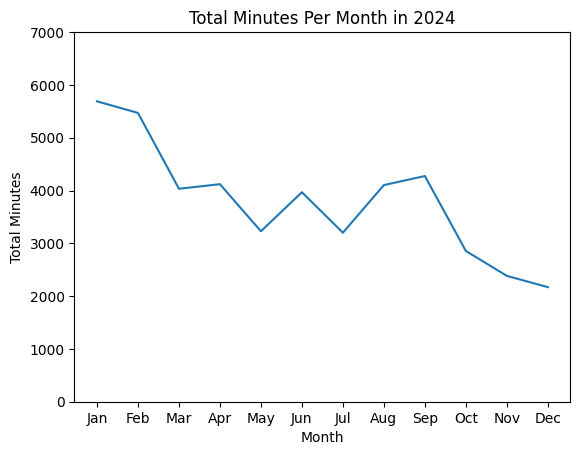

In [20]:
import matplotlib.pyplot as plt
import calendar

plot1 = (
    music_2024
    .groupby("month")["ms_played"]
    .sum()
    .sort_index() / 60000
).plot(kind = "line")

plot1.set_xticks(range(1, 13))
plot1.set_xticklabels(calendar.month_abbr[1:13])
plot1.set_ylim([0, 7000])
plot1.set_xlabel("Month")
plot1.set_ylabel("Total Minutes")
plot1.set_title("Total Minutes Per Month in 2024")

plt.show()

We can see that I listened to the most music in January, spiking back up again around September, and plummetting to end the year with December as the month with the least recorded minutes.

If this trend in cyclic, it's interesting to think that I go from the minimum listening to the maximum listening over the course of one month into a new year.

#### 2.5.6: BONUS Graphs of Yearly Music Listening

Note that the years 2015 and 2025 do not store 12 months of data like the others, so their low trends should be ignored. I could shorten my data to only show 2016-2024, but I like the idea of looking at a decade's worth of listening, incomplete as it may be.

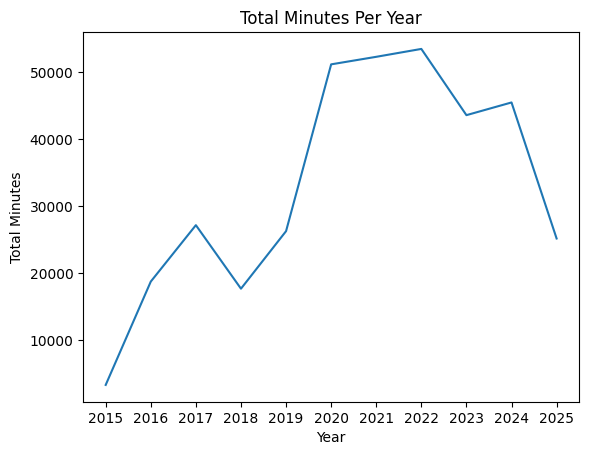

In [21]:
plot2 = (
    music
    .groupby(music["ts"].dt.year)["ms_played"]
    .sum()
    .sort_index() / 60000
).plot(kind="line")

plot2.set_xticks(range(2015, 2026))
plot2.set_xlabel("Year")
plot2.set_ylabel("Total Minutes")
plot2.set_title("Total Minutes Per Year")

plt.show()

It appears that 2022 was my top listening year (ignoring 2015 and 2025's incomplete data)

## PART 3: Analyzing Podcast Listening Habits


### 3.1: Total Time Spent Listening


In [ ]:
print(total_time(podcasts, "Podcasts"))

Total Time Spent Listening to Podcasts:
Minutes: 27649.9541
Hours:   460.8325683333333
Days:    19.201357013888888


## PART 4: Analyzing Audiobook Listening Habits


### 4.1: Total Time Spent Listening


In [15]:
print(total_time(audiobooks, "Audiobooks"))

Total Time Spent Listening to Audiobooks:
Minutes: 40.55521666666667
Hours:   0.6759202777777777
Days:    0.028163344907407406
